In [924]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numba import njit
import networkx as nx

In [925]:
def calcular_variancia_ruido(Eb_N0_dB):
    Eb_N0 = 10**(Eb_N0_dB / 10)
    N0 = 1 / Eb_N0
    sigma2 = N0 / 2
    return sigma2

In [926]:
variancia_ruido = calcular_variancia_ruido(200)
print(f"Variância do ruído: {variancia_ruido}")

Variância do ruído: 5e-21


In [927]:
def gerar_simbolos_bpsk(num_bits):
    return np.random.choice([-1, 1], num_bits)

In [928]:
simbolos_bpsk = gerar_simbolos_bpsk(10)
print(f"Símbolos BPSK gerados: {simbolos_bpsk}")

Símbolos BPSK gerados: [ 1  1 -1 -1 -1 -1  1  1 -1  1]


In [929]:
def calcular_valor_recebido(simbolos, Eb_N0_dB):
    sigma2 = calcular_variancia_ruido(Eb_N0_dB)
    sigma = np.sqrt(sigma2)
    ruido = sigma * np.random.randn(len(simbolos))
    r = simbolos + ruido
    return r

In [930]:
valores_recebidos = calcular_valor_recebido(simbolos_bpsk, 3)
print(f"Valores recebidos: {valores_recebidos}")

Valores recebidos: [ 1.06604296  1.66481711 -0.74547139 -0.99169307 -0.56204487 -0.13750259
  0.51059018  0.87179826 -0.49220571  0.68482954]


In [931]:
def calcular_valores_llr(r, sigma2):
    llr = 2 * r / sigma2
    return llr

In [932]:
Lc = calcular_valores_llr(valores_recebidos, variancia_ruido)
print(f"Valores LLR: {Lc}")

Valores LLR: [ 4.26417184e+20  6.65926845e+20 -2.98188555e+20 -3.96677229e+20
 -2.24817948e+20 -5.50010372e+19  2.04236073e+20  3.48719304e+20
 -1.96882284e+20  2.73931815e+20]


In [933]:
@njit
def set_params(N: int, dv: int, dc: int) -> tuple[int, int]:
    if (N  % dc != 0):
        raise ValueError("N must be divisible by dc")
    else:
        K = int(N / dc)
        M = int(K * dv)
        return (K, M)

In [934]:
N = 10
dv = 3
dc = 5
K, M = set_params(N, dv, dc)
print(f"K: {K}; M: {M}")

K: 2; M: 6


In [935]:
@njit
def generate_LDPC_matrix(N, dv, dc, K, M):
    H1 = np.zeros((K, N), dtype=np.int32)
    for i in range(len(H1)):
        H1[i][i * dc:(i + 1) * dc] = 1

    H = H1

    for _ in range(dv - 1):
        perm = np.random.permutation(N)
        H2 = H1[:, perm]
        H = np.concatenate((H, H2), axis=0)

    return H

In [936]:
H = generate_LDPC_matrix(N, dv, dc, K, M)
print(f"Matriz LDPC gerada: \n{H}")

Matriz LDPC gerada: 
[[1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1]
 [0 1 1 0 1 1 0 0 0 1]
 [1 0 0 1 0 0 1 1 1 0]
 [1 0 1 0 1 0 0 0 1 1]
 [0 1 0 1 0 1 1 1 0 0]]


In [937]:
def inicializar_mensagens(H):
    num_cnodes, num_vnodes = H.shape
    Le = np.zeros((num_cnodes, num_vnodes))  # Mensagens dos c-nodes para os v-nodes
    Lr = np.zeros((num_cnodes, num_vnodes))  # Mensagens dos v-nodes para os c-nodes
    return Le, Lr

In [938]:
Le, Lr = inicializar_mensagens(H)
print(f"Mensagens Le iniciais: {Le}")
print(f"Mensagens Lr iniciais: {Lr}")

Mensagens Le iniciais: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Mensagens Lr iniciais: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [939]:
def atualizar_mensagens_vnodes(Lr, Lc, Le, H):
    num_cnodes, num_vnodes = H.shape
    for i in range(num_vnodes):
        for j in range(num_cnodes):
            if H[j, i] == 1:
                Lr[j, i] = Lc[i] + np.sum(Le[:, i]) - Le[j, i]
    return Lr

In [940]:
Lr = atualizar_mensagens_vnodes(Lr, Lc, Le, H)
print(f"Mensagens Lr atualizadas: {Lr}")

Mensagens Lr atualizadas: [[ 4.26417184e+20  6.65926845e+20 -2.98188555e+20 -3.96677229e+20
  -2.24817948e+20  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -5.50010372e+19  2.04236073e+20  3.48719304e+20
  -1.96882284e+20  2.73931815e+20]
 [ 0.00000000e+00  6.65926845e+20 -2.98188555e+20  0.00000000e+00
  -2.24817948e+20 -5.50010372e+19  0.00000000e+00  0.00000000e+00
   0.00000000e+00  2.73931815e+20]
 [ 4.26417184e+20  0.00000000e+00  0.00000000e+00 -3.96677229e+20
   0.00000000e+00  0.00000000e+00  2.04236073e+20  3.48719304e+20
  -1.96882284e+20  0.00000000e+00]
 [ 4.26417184e+20  0.00000000e+00 -2.98188555e+20  0.00000000e+00
  -2.24817948e+20  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.96882284e+20  2.73931815e+20]
 [ 0.00000000e+00  6.65926845e+20  0.00000000e+00 -3.96677229e+20
   0.00000000e+00 -5.50010372e+19  2.04236073e+20  3.48719304e+20
   0.00

In [941]:
def atualizar_mensagens_cnodes(Le, Lr, H):
    num_cnodes, num_vnodes = H.shape
    for j in range(num_cnodes):
        for i in range(num_vnodes):
            if H[j, i] == 1:
                # Calcula o produto dos sinais
                product_sign = 1
                min_value = float('inf')
                for k in range(num_vnodes):
                    if k != i and H[j, k] == 1:
                        product_sign *= np.sign(Lr[j, k])
                        min_value = min(min_value, abs(Lr[j, k]))
                # Calcula a mensagem de saída usando a equação 11
                Le[j, i] = product_sign * min_value
    return Le

In [942]:
Le = atualizar_mensagens_cnodes(Le, Lr, H)
print(f"Mensagens Le atualizadas: {Le}")

Mensagens Le atualizadas: [[-2.24817948e+20 -2.24817948e+20  2.24817948e+20  2.24817948e+20
   2.98188555e+20  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.96882284e+20  5.50010372e+19  5.50010372e+19
  -5.50010372e+19  5.50010372e+19]
 [ 0.00000000e+00 -5.50010372e+19  5.50010372e+19  0.00000000e+00
   5.50010372e+19  2.24817948e+20  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -5.50010372e+19]
 [ 1.96882284e+20  0.00000000e+00  0.00000000e+00 -1.96882284e+20
   0.00000000e+00  0.00000000e+00  1.96882284e+20  1.96882284e+20
  -2.04236073e+20  0.00000000e+00]
 [-1.96882284e+20  0.00000000e+00  1.96882284e+20  0.00000000e+00
   1.96882284e+20  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.24817948e+20 -1.96882284e+20]
 [ 0.00000000e+00  5.50010372e+19  0.00000000e+00 -5.50010372e+19
   0.00000000e+00 -2.04236073e+20  5.50010372e+19  5.50010372e+19
   0.00

In [943]:
def iteracao(Lc, Le, Lr, H):
    num_cnodes = H.shape[0]
    # Atualizar mensagens dos v-nodes
    Lr = atualizar_mensagens_vnodes(Lr, Lc, Le, H)
    
    # Atualizar mensagens dos c-nodes
    Le = atualizar_mensagens_cnodes(Le, Lr, H)
    
    criteria_met = np.zeros(num_cnodes, dtype=int)
    
    for i in range(num_cnodes):
        # Índices dos v-nodes conectados ao c-node i
        connected_v_nodes = np.where(H[i, :] == 1)[0]
        
        # Mensagens de entrada para o c-node i
        incoming_messages = Le[i, connected_v_nodes]
        
        product_of_signs = np.prod(np.sign(incoming_messages))
        
        # Critério atendido se o produto dos sinais for positivo
        criteria_met[i] = int(product_of_signs > 0)
            
    return criteria_met

In [944]:
n = 0

In [945]:
n += 1
criteria_met = iteracao(Lc, Le, Lr, H)
print(f"Iteração n: {n}")
print(f"Mensagens Decision atualizada: {criteria_met}")
print(f"Símbolos BPSK gerados:         {simbolos_bpsk}")
print(f"Mensagens Le atualizada: {Le}")
print(f"Mensagens Lr atualizada: {Lr}")

Iteração n: 1
Mensagens Decision atualizada: [1 1 1 1 1 1]
Símbolos BPSK gerados:         [ 1  1 -1 -1 -1 -1  1  1 -1  1]
Mensagens Le atualizada: [[ 2.70653727e+19  2.70653727e+19 -2.70653727e+19 -2.70653727e+19
   4.63052344e+19  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -2.20484944e+19  2.20484944e+19  2.20484944e+19
  -2.20484944e+19  3.44191623e+19]
 [ 0.00000000e+00 -1.23511677e+20 -1.32050569e+20  0.00000000e+00
  -1.23511677e+20  1.23511677e+20  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.23511677e+20]
 [ 2.70653727e+19  0.00000000e+00  0.00000000e+00 -4.71695158e+18
   0.00000000e+00  0.00000000e+00  4.71695158e+18  4.71695158e+18
  -4.71695158e+18  0.00000000e+00]
 [ 1.83695699e+19  0.00000000e+00 -1.28371644e+20  0.00000000e+00
   1.83695699e+19  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.83695699e+19  1.83695699e+19]
 [ 0.00000000e+00 

In [946]:
def ldpc_decode(Lc, H, max_iter=100):
    Le, Lr = inicializar_mensagens(H)
    n = 0

    for iteration in range(max_iter):
        n += 1
        criteria_met = iteracao(Lc, Le, Lr, H)
        if np.all(criteria_met == 0):
            break
    
    print(f"{n} iterações")
    # Decisão final
    Lf = Lc + np.sum(Le, axis=0)
    decoded_bits = np.sign(Lf)
    return decoded_bits

In [947]:
bits_decodificados = ldpc_decode(Lc, H)
print(f"Bits gerados:       {simbolos_bpsk}")
print(f"Bits decodificados: {bits_decodificados}")


100 iterações
Bits gerados:       [ 1  1 -1 -1 -1 -1  1  1 -1  1]
Bits decodificados: [ 1.  1. -1. -1.  1. -1.  1.  1. -1.  1.]


In [948]:
def calcular_ber(bits_originais, bits_decodificados):

    erros = np.count_nonzero(bits_originais != bits_decodificados)
    ber = erros / len(bits_originais)
    return ber

In [949]:
ber = calcular_ber(simbolos_bpsk, bits_decodificados)
print(f"Ber: {ber}")

Ber: 0.1


In [950]:
def simular_desempenho_ldpc(H, num_bits, Eb_N0_dB_range, max_iter=50):
    ber_results = []
    
    for Eb_N0_dB in Eb_N0_dB_range:
        # Gerar símbolos BPSK
        simbolos = gerar_simbolos_bpsk(num_bits)
        
        # Calcular valores recebidos com ruído
        r = calcular_valor_recebido(simbolos, Eb_N0_dB)
        
        # Calcular valores LLR
        sigma2 = calcular_variancia_ruido(Eb_N0_dB)
        Lc = calcular_valores_llr(r, sigma2)
        
        # Decodificar
        bits_decodificados = ldpc_decode(Lc, H, max_iter=max_iter)
        
        # Calcular BER
        ber = calcular_ber(simbolos, bits_decodificados)
        ber_results.append(ber)
        
    return ber_results

In [951]:
# Definindo os parâmetros para simulação
num_bits = 999
Eb_N0_dB_range = np.arange(0, 5.5, 0.5)

In [952]:
# Gerando a matriz LDPC
N = num_bits
dv = 4
dc = 9
K, M = set_params(N, dv, dc)
H = generate_LDPC_matrix(N, dv, dc, K, M)

In [953]:
# Simulando o desempenho
ber_results = simular_desempenho_ldpc(H, num_bits, Eb_N0_dB_range)

50 iterações
50 iterações
50 iterações
50 iterações
50 iterações
50 iterações
50 iterações
50 iterações
50 iterações
50 iterações
50 iterações


In [954]:
def plotar_ber(Eb_N0_dB_range, ber_results):
    plt.figure(figsize=(10, 6))
    plt.plot(Eb_N0_dB_range, ber_results, marker='o', linestyle='-', color='b')
    plt.yscale('log')
    plt.xlabel('Eb/N0 (dB)')
    plt.ylabel('Taxa de Erro de Bit (BER)')
    plt.title('Desempenho do Código LDPC')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

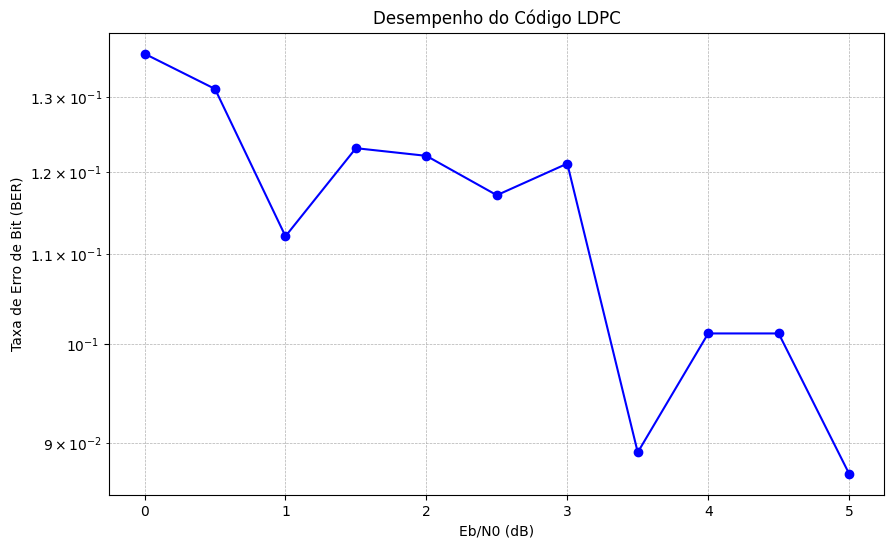

In [955]:
# Plotar o gráfico
plotar_ber(Eb_N0_dB_range, ber_results)

In [956]:
def encontrar_menor_eb_n0(ber_results, Eb_N0_dB_range, threshold=1e-4):
    for Eb_N0_dB, ber in zip(Eb_N0_dB_range, ber_results):
        if ber < threshold:
            return Eb_N0_dB
    return None

# Encontrar o menor valor de Eb/N0 para BER < 10^-4
menor_eb_n0 = encontrar_menor_eb_n0(ber_results, Eb_N0_dB_range)
print(f"Menor valor de Eb/N0 para BER < 10^-4: {menor_eb_n0} dB")

Menor valor de Eb/N0 para BER < 10^-4: None dB


In [143]:
import csv

def gerar_grafo_csv(H, filename='grafo_ldpc.csv'):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        for row in H:
            indices = np.where(row == 1)[0]
            writer.writerow(indices)

# Exemplo de matriz H para N ≈ 1000
H = generate_LDPC_matrix(N, dv, dc, K, M)

# Gerar arquivo CSV
gerar_grafo_csv(H)